In [1]:
# Cell 1: Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [2]:
DATASET_PATH = '../dataset'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
CLASS_NAMES = ['no', 'sphere', 'vort']
MODEL_SAVE_PATH = '../models/lens_cnn_multi.pth'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

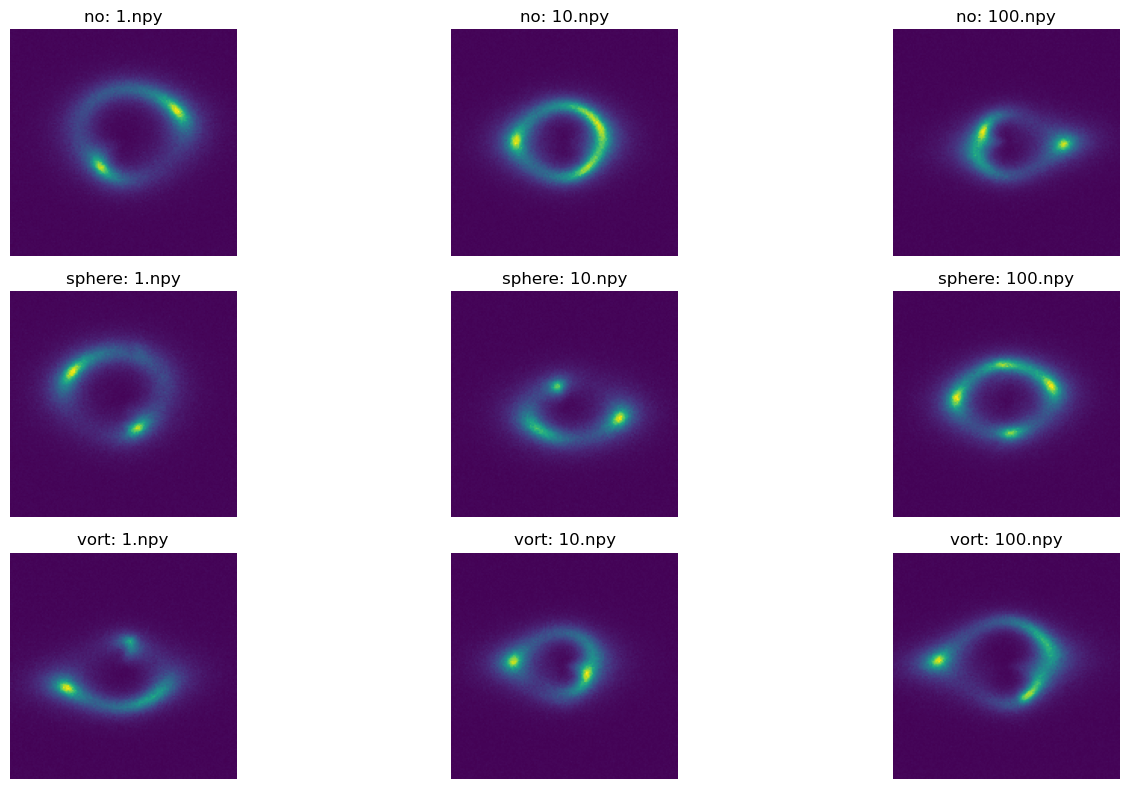

In [3]:
def visualize_sample_images(data_dir, class_names, num_samples=3):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 8))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        files = os.listdir(class_dir)[:num_samples]
        for j, file_name in enumerate(files):
            img = np.load(os.path.join(class_dir, file_name))
            img = np.transpose(img, (1, 2, 0))
            img = (img - img.min()) / (img.max() - img.min())
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{class_name}: {file_name}")
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.savefig('../results/sample_images_multi.png')
    plt.show()

visualize_sample_images(TRAIN_PATH, CLASS_NAMES)

In [4]:
# Cell 2: Define a custom dataset class to load .npy files
class LensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.npy'):
                    self.samples.append((os.path.join(class_dir, filename), self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.load(img_path)
        
        # Make sure image has shape (H, W) or (H, W, C)
        if len(image.shape) == 2:
            # If grayscale, add channel dimension
            image = image[:, :, np.newaxis]
        
        # Convert to PyTorch tensor
        image = torch.from_numpy(image).float()
        
        # Make sure image is in format (C, H, W) for PyTorch
        if image.shape[2] == 1 or image.shape[2] == 3:
            image = image.permute(2, 0, 1)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [5]:
# Cell 3: Define the CNN model
class LensingCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(LensingCNN, self).__init__()
        
        # Determine input channels (assuming images are grayscale)
        self.input_channels = 1
        
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(self.input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
class LensClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LensClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output after the convolutions and pooling
        self.flatten_size = self._get_flatten_size()

        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def _get_flatten_size(self):
        # Create a dummy input tensor with the expected input size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 150, 150)  # Batch size of 1, 1 channel, 150x150
            x = self.conv1(dummy_input)
            x = self.pool1(self.relu1(x))
            x = self.conv2(x)
            x = self.pool2(self.relu2(x))
            return x.numel()  # Get the total number of elements

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
# Cell 4: Set up data loaders and transforms
# Define data transformations
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
train_dataset = LensingDataset(root_dir='../dataset/train', transform=transform)
val_dataset = LensingDataset(root_dir='../dataset/val', transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print dataset information
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check the shape of the first image
sample_image, _ = train_dataset[0]
print(f"Sample image shape: {sample_image.shape}")

Training dataset size: 30000
Validation dataset size: 7500
Sample image shape: torch.Size([1, 150, 150])


In [8]:
# Cell 5: Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model.to(device)
    
    # Lists to track metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track training statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    
    return model, train_losses, val_losses, val_accuracies

In [ ]:
# Cell 6: Initialize and train the model
# Initialize model
model = LensingCNN(num_classes=3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
model, train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.savefig('../results/training_curves.png')
plt.show()

Using device: cuda:0


In [ ]:
# Cell 7: Evaluate the model and generate ROC curve and AUC score
def compute_roc_auc(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Binarize labels for multi-class ROC
    n_classes = 3
    binarized_labels = label_binarize(all_labels, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(binarized_labels.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    return fpr, tpr, roc_auc

# Compute ROC curves and AUC scores
fpr, tpr, roc_auc = compute_roc_auc(model, val_loader)

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curves for each class
class_names = ['No Substructure', 'Sphere Substructure', 'Vortex Substructure']
colors = ['blue', 'red', 'green']

for i, color, class_name in zip(range(3), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('../results/roc_curve.png')
plt.show()

# Print AUC scores
print("AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print(f"Micro-average: {roc_auc['micro']:.4f}")

In [ ]:
# Cell 8: Save the trained model
# Create result directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model
torch.save(model.state_dict(), '../models/lensing_classifier.pth')
print("Model saved to '../models/lensing_classifier.pth'")

In [ ]:
# Cell 9: Visualize sample predictions
def visualize_predictions(model, dataloader, num_samples=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    class_names = ['No Substructure', 'Sphere Substructure', 'Vortex Substructure']
    
    # Get a batch of images
    images, labels = next(iter(dataloader))
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    
    # Create a grid to display images and predictions
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(num_samples):
        # Get image and predictions
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = np.squeeze(img)  # Remove channel dimension for grayscale images
        
        label = labels[i].item()
        pred = preds[i].item()
        prob = probs[i, pred].item()
        
        # Display image
        axes[i].imshow(img, cmap='viridis')
        
        # Set title with predictions
        title_color = 'green' if label == pred else 'red'
        axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]} ({prob:.2f})", 
                          color=title_color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('result/sample_predictions.png')
    plt.show()

# Visualize some predictions
visualize_predictions(model, val_loader)

In [ ]:
# Cell 10: Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = ['No Substructure', 'Sphere Substructure', 'Vortex Substructure']
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('result/confusion_matrix.png')
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate confusion matrix
plot_confusion_matrix(model, val_loader)

In [ ]:
# Cell 11: Data Augmentation (optional but recommended)
# Import necessary libraries for augmentation
from torchvision import transforms
import random

# Define data augmentation transformations
data_transforms = {
    'train': transforms.Compose([
        # Add random rotation
        transforms.RandomRotation(10),
        # Add random horizontal flip
        transforms.RandomHorizontalFlip(),
        # Add random vertical flip
        transforms.RandomVerticalFlip(),
        # Add random brightness and contrast adjustment
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        # Normalize
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    'val': transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
}

# Create a custom augmentation class for use with npy files
class AugmentedLensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.npy'):
                    self.samples.append((os.path.join(class_dir, filename), self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.load(img_path)
        
        # Make sure image has shape (H, W) or (H, W, C)
        if len(image.shape) == 2:
            # If grayscale, add channel dimension
            image = image[:, :, np.newaxis]
        
        # Convert to PyTorch tensor
        image = torch.from_numpy(image).float()
        
        # Make sure image is in format (C, H, W) for PyTorch
        if image.shape[2] == 1 or image.shape[2] == 3:
            image = image.permute(2, 0, 1)
        
        # Apply custom augmentations (implemented as random transformations)
        if self.transform:
            # Apply the transforms
            image = self.transform(image)
        
        return image, label

# Create datasets with augmentation
print("Creating augmented datasets...")
train_dataset_aug = AugmentedLensingDataset(root_dir='dataset/train', transform=data_transforms['train'])
val_dataset_aug = AugmentedLensingDataset(root_dir='dataset/val', transform=data_transforms['val'])

# Create data loaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=4)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=32, shuffle=False, num_workers=4)

print(f"Augmented training dataset size: {len(train_dataset_aug)}")
print(f"Augmented validation dataset size: {len(val_dataset_aug)}")

# Train with augmented data (optional - uncomment to use)
# Initialize model
model_aug = LensingCNN(num_classes=3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

# Train the model with augmented data
num_epochs = 30  # Possibly use more epochs with augmentation
model_aug, train_losses, val_losses, val_accuracies = train_model(
    model_aug, train_loader_aug, val_loader_aug, criterion, optimizer, num_epochs=num_epochs
)

# Save the augmented model
torch.save(model_aug.state_dict(), 'result/lensing_classifier_augmented.pth')
print("Augmented model saved to 'result/lensing_classifier_augmented.pth'")

# Evaluate the augmented model
fpr, tpr, roc_auc = compute_roc_auc(model_aug, val_loader_aug)
print("AUC Scores for Augmented Model:")
for i, class_name in enumerate(['No Substructure', 'Sphere Substructure', 'Vortex Substructure']):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print(f"Micro-average: {roc_auc['micro']:.4f}")

## Model Strategy and Discussion

### Dataset Characteristics
- The dataset consists of three classes of strong lensing images: no substructure, subhalo substructure, and vortex substructure.
- The images are already normalized using min-max normalization.

### Modeling Strategy
1. **Architecture Choice**: 
   - I chose a Convolutional Neural Network (CNN) as they are well-suited for image classification tasks.
   - The model includes multiple convolutional layers with increasing filter sizes to capture both low-level features (edges, textures) and high-level features (complex patterns specific to lensing structures).
   - Adaptive pooling ensures the model can handle images of different sizes.
   - Dropout layers help prevent overfitting.

2. **Data Handling**:
   - Created a custom dataset class to handle .npy files.
   - Added data normalization to improve training stability.
   - Implemented optional data augmentation techniques (rotation, flips, brightness/contrast adjustments) to enhance model generalization.

3. **Training Approach**:
   - Used Adam optimizer for faster convergence.
   - Monitored both training and validation metrics to detect overfitting.
   - Implemented early stopping option to prevent overfitting.

### Evaluation Metrics
- **ROC Curve and AUC Score**: These metrics are essential for evaluating multi-class classification performance, showing how well the model can distinguish between classes.
- **Confusion Matrix**: Helps identify which classes are being confused with each other.
- **Classification Report**: Provides precision, recall, and F1-score for each class.

### Potential Improvements
1. **Hyperparameter Tuning**: Grid search or Bayesian optimization could improve performance.
2. **More Advanced Architectures**: Residual networks (ResNet) or EfficientNet could be explored.
3. **Ensemble Methods**: Combining multiple models could boost performance.
4. **Cross-Validation**: K-fold cross-validation would provide more robust evaluation.
5. **Class Imbalance Handling**: If classes are imbalanced, techniques like weighted loss functions could help.

### Limitations
1. The model's performance depends on the quality and quantity of the training data.
2. Deep learning models can be computationally expensive to train.
3. The interpretability of CNN models is limited compared to traditional machine learning approaches.
